In [50]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy import stats
import math
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import savgol_filter
from bar_funcs import *

In [51]:
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 15

In [187]:
#path = 'barrada/'
path = 'satelites/sat1-10/'
paths1 = [path]

#n_snapshots_ = 281
n_snapshots_ = 121

In [194]:
#teste
snapshot = path + f'snapshot_060.hdf5'

#ler snapshot
f = h5py.File(snapshot, 'r')
time = 0.0 + round(f['Header'].attrs['Time'], 2)

#ler info disco e corrigir posição - centro de massa
f_disk = f['PartType2']

x_disk = np.array(f_disk['Coordinates'][:,0])
y_disk = np.array(f_disk['Coordinates'][:,1])
z_disk = np.array(f_disk['Coordinates'][:,2])
m_disk = np.array(f_disk['Masses'])
vx_disk = np.array(f_disk['Velocities'][:,0])
vy_disk = np.array(f_disk['Velocities'][:,1])
vz_disk = np.array(f_disk['Velocities'][:,2])
Ndisk = len(np.array(f_disk['ParticleIDs']))
id = np.array(f_disk['ParticleIDs'])
                   
x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

#corrigir posição - momento angular
theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)

#calcular orientação
orientation_bar = theta_bar(m=m_disk, x=x, y=y, Rmax=10.0)
orientation_warp = theta_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Rmin=20.0)

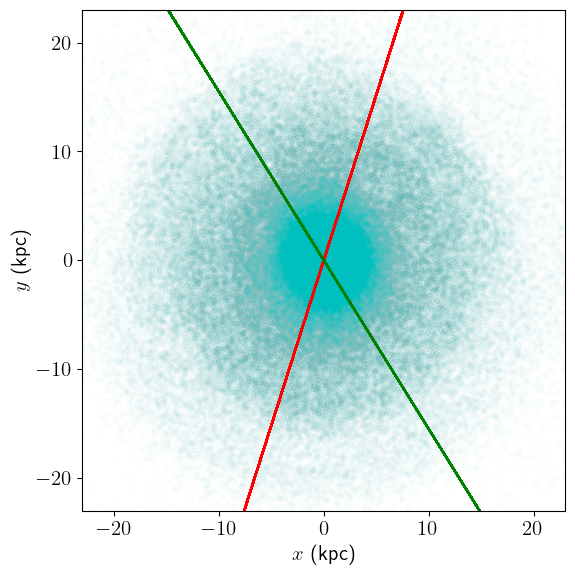

In [197]:
a_bar = 1/np.tan((np.pi/2)-abs(orientation_bar))
a_warp = 1/np.tan((np.pi/2)-abs(orientation_warp))

linha_bar = a_bar * x
linha_warp = -a_warp * x

plt.figure(figsize=[6,6])
plt.plot(x, y, '.', alpha=0.01, color='c')
plt.plot(x, linha_bar, 'r-')
plt.plot(x, linha_warp, 'g-')
plt.xlabel('$x$ (kpc)', fontsize=15)
plt.ylabel('$y$ (kpc)', fontsize=15)
plt.xlim(-23,23)
plt.ylim(-23,23)
plt.tight_layout()

/tmp/ipykernel_21486/3019257551.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


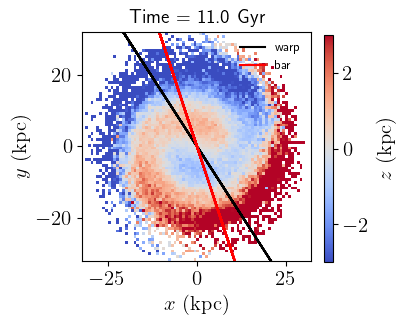

In [196]:
#mapas de posição e velocidade
Nbins = 80

Rmax =  32.0 #kpc
xmin = ymin = -Rmax
xmax = ymax = Rmax

results, xb, yb, binnum = stats.binned_statistic_2d(x, y, z, statistic='mean',
                                                    bins=Nbins, range=[[xmin,xmax],[ymin,ymax]])
extent = [xb[0], xb[-1], yb[0], yb[-1]]    
Q = results

a_bar = 1/np.tan((np.pi/2)-abs(orientation_bar))
a_warp = 1/np.tan((np.pi/2)-abs(orientation_warp))
linha_bar = -a_bar * x
linha_warp = -a_warp * x

    
fig = plt.figure()
ax1  = plt.subplot(111)
fig.set_size_inches(4.5,3.5)
im = plt.imshow(Q.T, extent=extent, origin='lower', cmap="coolwarm", interpolation='nearest', 
                            vmin=-3, vmax=3)
plt.plot(x, linha_warp, 'k-', label='warp')
plt.plot(x, linha_bar, 'r-', label='bar')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
ax1.set_aspect('equal')
ax1.set_title(f'Time = {time+8} Gyr', fontsize=14)
plt.legend(frameon=False, fontsize=9)
cb = fig.add_axes([0.82, 0.215, 0.020, 0.65])
cb = fig.colorbar(im, cax=cb, orientation="vertical")
cb.set_label(r'$z~({\rm kpc})$')
ax1.set_xlabel(r'$x~({\rm kpc})$')
ax1.set_ylabel(r'$y~({\rm kpc})$')
    
plt.tight_layout()
plt.savefig('theta_w_problemas6.png')

In [53]:
time = np.empty(n_snapshots_)
orientation_bar = np.empty(n_snapshots_)
orientation_warp = np.empty(n_snapshots_)

In [ ]:
%%time
for p, path in enumerate(paths1):

    for j in range (0, n_snapshots_):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time[j] = 0.0 + round(f['Header'].attrs['Time'], 2)

        #ler info disco e corrigir posição - centro de massa
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        Ndisk = len(np.array(f_disk['ParticleIDs']))
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

        #corrigir posição - momento angular
        theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
        x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
        x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)
        
        #calcular orientação
        if p == 0:
            orientation_bar[j] = theta_bar(m=m_disk, x=x, y=y, Rmax=10.0)
            orientation_warp[j] = theta_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Rmin=20.0)

In [ ]:
time_ = time + 8.0

plt.figure(figsize=[6,6])
plt.plot(time, orientation_bar, 'k-', label=r'$\theta_b$')
plt.plot(time, orientation_warp, 'y-', label=r'$\theta_w$')
ylims=[(-1.1) * np.pi, 1.1 * np.pi]
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'])
plt.ylim(ylims)
plt.xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
plt.ylabel(r'$\theta~$')
plt.xlabel(r'$t~({\rm Gyr})$')
# plt.title(f'Time = {time} Gyr')
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig(f'theta-w-barrada.png')